In [1]:
import torch
from torch import nn, optim
from kilroyplot.plot import plt

In [2]:
n_choices = 10

In [3]:
rewards = torch.distributions.uniform.Uniform(-1, 1).sample((n_choices,)) 
rewards

tensor([ 0.3984,  0.0805, -0.0121, -0.4044, -0.3827,  0.6711,  0.5235,  0.9235,
         0.7808, -0.3980])

In [4]:
class Actor(nn.Module):
    def __init__(self, n_out, n_hidden=10):
        super().__init__()
        self.x = torch.ones(1)
        self.layers = nn.Sequential(
            nn.Linear(1, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_out),
            nn.Softmax(-1)
        )

    def forward(self):
        return self.layers(self.x)

In [5]:
class Critic(nn.Module):
    def __init__(self, n_in, n_hidden=10):
        super().__init__()
        self.x = torch.ones(n_hidden)
        self.layers = nn.Sequential(
            nn.Linear(n_in, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, 1)
        )

    def forward(self, x):
        return self.layers(x)

In [6]:
class Sampler:
    def __init__(self, weights):
        self.sampler = torch.distributions.categorical.Categorical(weights)
        
    def sample(self, n=1):
        return  self.sampler.sample((n,))

In [7]:
class OneHotEncoder:
    def __init__(self, n):
        self.n = n
        
    def encode(self, x):
        return nn.functional.one_hot(x, self.n)

In [8]:
actor = Actor(n_choices)
critic = Critic(n_choices)

In [9]:
encoder = OneHotEncoder(n_choices)

In [10]:
actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)
critic_optimizer = optim.Adam(critic.parameters(), lr=0.005)

In [11]:
critic_loss = nn.MSELoss()

In [12]:
epochs = 1000
actor_iters = 10000
critic_iters = 10

In [13]:
critic_losses = []
actor_losses = []
actor_rewards = []

for _ in range(epochs):
    critic_optimizer.zero_grad()
    choice = Sampler(actor()).sample(critic_iters)
    x = encoder.encode(choice)
    pred_reward = critic(x.float())
    real_reward = rewards[choice].unsqueeze(-1)
    loss = critic_loss(pred_reward, real_reward)
    loss.backward()
    critic_optimizer.step()

    critic_losses.append(loss.item())
    
    actor_optimizer.zero_grad()
    probs = actor()
    choice = Sampler(probs).sample(actor_iters)
    x = encoder.encode(choice)
    reward = critic(x.float())
    loss = -(reward * torch.log(probs[choice].unsqueeze(-1))).mean()
    loss.backward()
    actor_optimizer.step()
    
    actor_losses.append(loss.item())
    actor_rewards.append(reward.mean().item())

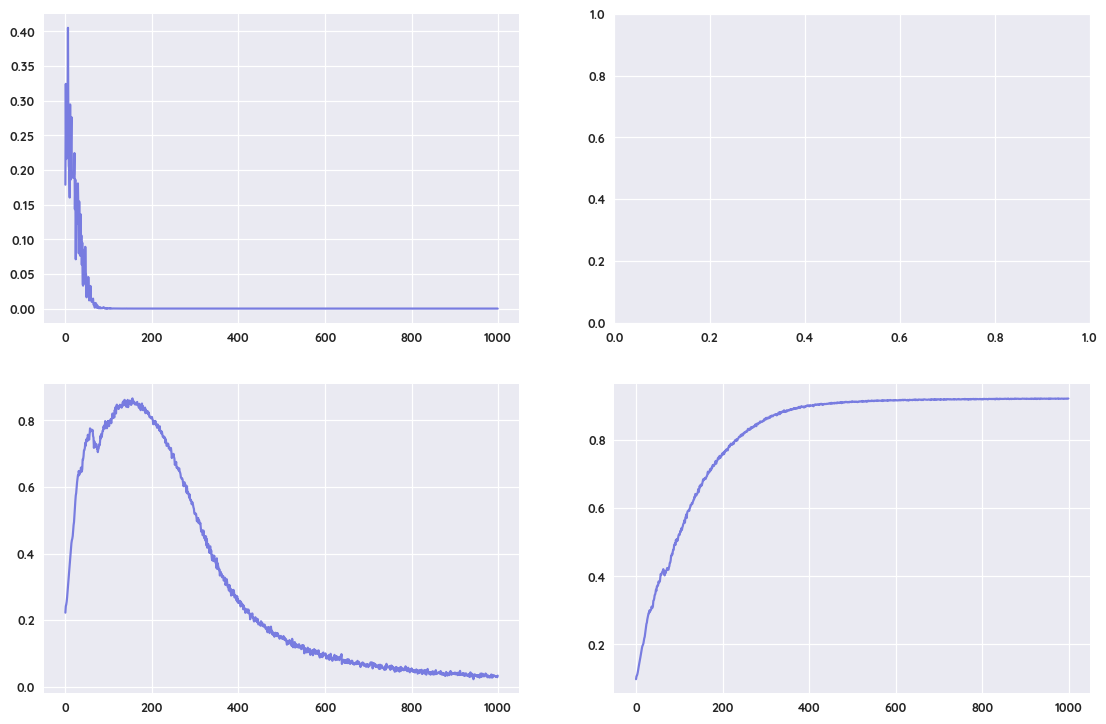

In [14]:
_, axs = plt.subplots(2, 2, figsize=(15, 10))
axs[0][0].plot(critic_losses)
axs[1][0].plot(actor_losses)
axs[1][1].plot(actor_rewards)

<BarContainer object of 10 artists>

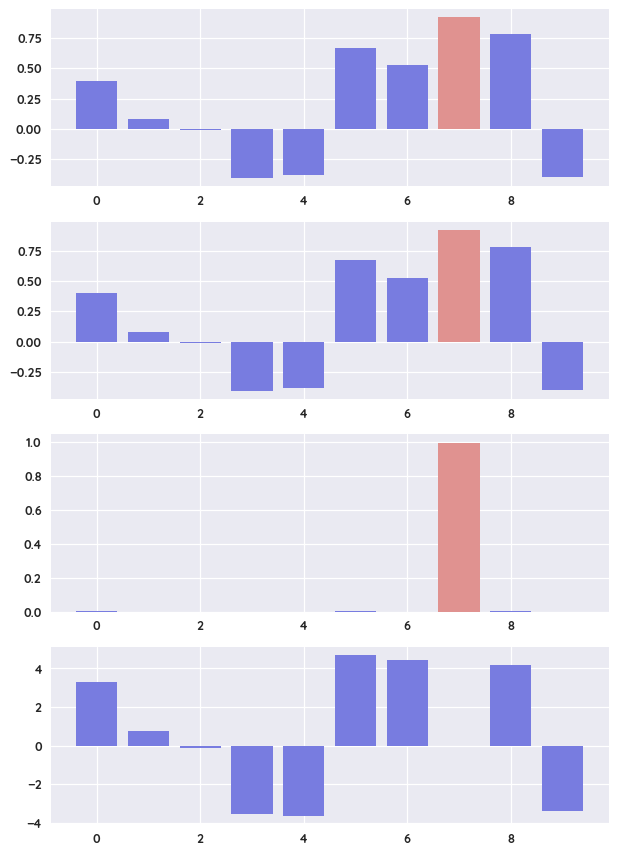

In [15]:
color=['C1' if i == actor().argmax() else 'C0' for i in range(n_choices)]
_, axs = plt.subplots(4, 1, figsize=(8, 12))
axs[0].bar(range(n_choices), rewards, color=color)
choice = torch.arange(n_choices)
reward = critic(encoder.encode(choice).float())
axs[1].bar(range(n_choices), reward.flatten().detach().numpy(), color=color)
probs = actor()
loss = -(reward * torch.log(probs[choice].unsqueeze(-1)))
axs[2].bar(range(n_choices), probs.detach().numpy(), color=color)
axs[3].bar(range(n_choices), loss.flatten().detach().numpy(), color=color)